# Survival analysis on BRCA TCGA data 

## TODO: notebook for each cohort

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score

from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.nonparametric import kaplan_meier_estimator

from tqdm import tqdm

from pathway_forte.constants import *
from pathway_forte.gsea import *
from pathway_forte.regression import *
from pathway_forte.survival_analysis import *

In [2]:
%matplotlib inline

In [29]:
EVENT_TIME_PATH = os.path.join(DATA, 'tcga_datasets', 'brca', 'event_time_matrix.txt')
SSGSEA_NES = os.path.join(REACTOME_SSGSEA,'reactome_brca.tsv')
normal_samples = NORMAL_EXPRESSION_SAMPLES.format('brca')

In [30]:
# Get number of healthy samples in dataset
normal_sample_size = get_num_samples(normal_samples)

In [31]:
filtered_ssgsea_df, event_time_array = ssgsea_survival_analysis(EVENT_TIME_PATH, SSGSEA_NES, normal_sample_size)

In [32]:
filtered_ssgsea_df.head()

Term|NES,R-HSA-109581,R-HSA-109582,R-HSA-109606,R-HSA-109688,R-HSA-109704,R-HSA-110312,R-HSA-110313,R-HSA-110314,R-HSA-110320,R-HSA-110373,...,R-HSA-983168,R-HSA-983169,R-HSA-983170,R-HSA-983189,R-HSA-983231,R-HSA-983695,R-HSA-983705,R-HSA-983712,R-HSA-991365,R-HSA-997272
0,0.269665,0.107719,0.244021,0.323225,-0.0392768,0.404168,0.280483,0.353306,0.39156,0.315356,...,0.201961,0.21235,0.336833,0.107377,0.0974685,0.244859,0.28199,0.00714312,-0.059633,-0.0548265
1,0.26747,0.12842,0.249358,0.290609,-0.0612771,0.293983,0.223109,0.2389,0.284587,0.222888,...,0.169195,0.188313,0.36041,0.00313062,0.0624618,0.193805,0.25133,0.0180777,-0.0312022,-0.047457
2,0.270779,0.0614002,0.24868,0.292485,-0.0662815,0.327123,0.266218,0.275562,0.320995,0.274318,...,0.180928,0.195489,0.338007,0.0253469,0.0534023,-0.147427,0.107001,-0.00379126,-0.0576295,-0.0591741
3,0.278643,0.0832561,0.259806,0.302232,-0.0410069,0.334807,0.272547,0.309583,0.338581,0.292086,...,0.205934,0.21518,0.403742,0.0726762,0.0807131,0.0737691,0.196866,0.0480242,-0.0338411,-0.0670078
4,0.263509,0.0964957,0.249497,0.296182,-0.0163263,0.32772,0.258938,0.286895,0.317689,0.272353,...,0.184822,0.198191,0.370071,0.0459337,0.0755294,0.0824052,0.197072,0.0195609,-0.0546321,-0.0741971


In [33]:
event_time_array

array([( True,   0.), ( True,   0.), ( True,   0.), ..., ( True,   0.),
       ( True,   0.), (False, 158.)],
      dtype=[('status', '?'), ('days_death', '<f8')])

Text(0.5, 0, 'time $t$')

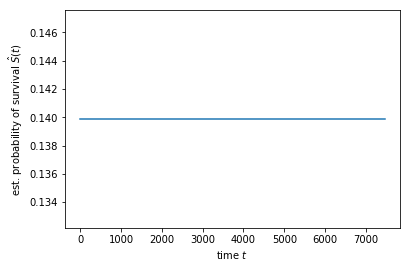

In [34]:
# Plot probability that patient survives beyond a given time point
time, survival_prob = kaplan_meier_estimator(event_time_array["status"], event_time_array["days_death"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [35]:
n_censored = event_time_array.shape[0] - event_time_array["status"].sum()
print("%.1f%% of records are censored" % (n_censored / event_time_array.shape[0] * 100))

14.0% of records are censored


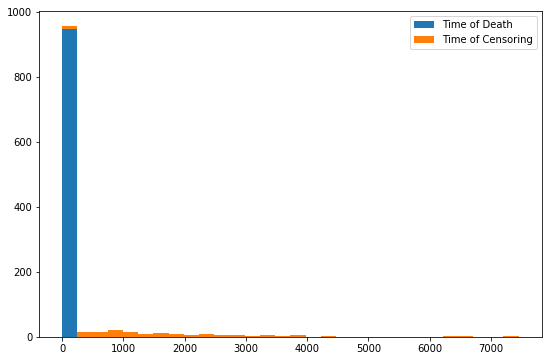

In [36]:
plt.figure(figsize=(9, 6))
val, bins, patches = plt.hist((event_time_array["days_death"][event_time_array["status"]],
                               event_time_array["days_death"][~event_time_array["status"]]),
                              bins=30, stacked=True)
plt.legend(patches, ["Time of Death", "Time of Censoring"])

#### Survival analysis

In [37]:
def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y['status'], y['days_death'], prediction)
    return result[0]

In [38]:
params = get_parameter_values_for_elastic_net()

parameters_dict = {
    "l1_ratio": np.arange(0.01, 1.0, 0.1)
}

# parameters_dict = {"max_iter": [1, 5],
#                     "l1_ratio": [0.1,0.5,0.8,0.9]}

### Perform inner cross validation for parameter tuning via GridSearchCV
1. Set parameter to tune to some value
2. Split data into K-folds
3. Train model using K-1 folds using a parameter value
4. Test model on the remaining fold
5. Repeat steps 3 and 4 so that every fold is the test data once
6. Repeat steps 1 to 5 for every possible value of the parameter

In [40]:
concordance_scores = []

kf = KFold(n_splits=10, shuffle=True)
inner_cv = KFold(n_splits=10)

iterator = tqdm(kf.split(filtered_ssgsea_df, event_time_array))

for i, (train_index, test_index) in enumerate(iterator):
    
    X_train = filtered_ssgsea_df.iloc[train_index]
    
    X_test= filtered_ssgsea_df.iloc[test_index]
    
    y_train, y_test = np.asarray([event_time_array[i] for i in train_index]), np.asarray([event_time_array[i] for i in test_index])
    
    
    # Instantiate Cox’s proportional hazard’s regression model with elastic net penalty
    # regression model
    coxnet = CoxnetSurvivalAnalysis()
    
    # Tune hyper-parameters (e.g., L1-ratio) of the estimator using grid search
    gcv = GridSearchCV(estimator=coxnet, param_grid=parameters_dict, cv=inner_cv)
    gcv.fit(X_train, y_train)  
    
    # gcv.best_estimator_.parameters_dict  
    print(gcv.best_estimator_.l1_ratio)
    
    # Evaluate the performance of the model during grid search using Harrell's concordance index
    prediction = gcv.predict(X_test)
    
    result = concordance_index_censored(
        [event_time_array[i]['status'] for i in test_index], # Get the status array for test set
        [event_time_array[i]['days_death'] for i in test_index], # Get the days to death for test set
        prediction # Prediction scores
    )
    print('c-index {}'.format(result[0]))
    concordance_scores.append(result[0])






0it [00:00, ?it/s]

0.01
c-index 0.5934343434343434







1it [00:34, 34.10s/it]

0.91
c-index 0.5678191489361702







2it [01:09, 34.61s/it]

0.91
c-index 0.6101190476190477







3it [01:43, 34.63s/it]

0.7100000000000001
c-index 0.4968421052631579







4it [02:18, 34.62s/it]

0.41000000000000003
c-index 0.6566666666666666







5it [02:52, 34.55s/it]

0.6100000000000001
c-index 0.7031578947368421







6it [03:28, 34.73s/it]

0.81
c-index 0.4908802537668517







7it [04:04, 34.87s/it]

0.7100000000000001
c-index 0.6037414965986394







8it [04:38, 34.80s/it]

0.81
c-index 0.46279761904761907







9it [05:12, 34.72s/it]

0.31000000000000005
c-index 0.5057471264367817







10it [05:47, 34.79s/it]






In [41]:
concordance_scores

[0.5934343434343434,
 0.5678191489361702,
 0.6101190476190477,
 0.4968421052631579,
 0.6566666666666666,
 0.7031578947368421,
 0.4908802537668517,
 0.6037414965986394,
 0.46279761904761907,
 0.5057471264367817]

In [17]:
coxnet.get_params().keys()

dict_keys(['alpha_min_ratio', 'alphas', 'copy_X', 'l1_ratio', 'max_iter', 'n_alphas', 'normalize', 'penalty_factor', 'tol', 'verbose'])

In [ ]:
# Show the best value for l1 ratio
gcv.best_estimator_.l1_ratio

In [ ]:
sorted(gcv.cv_results_.keys())